In [ ]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

# Training a classifier

In [ ]:
from steel_segmentation.core import *
from steel_segmentation.data import *
from fastcore.foundation import *
from fastai.vision.all import *
import fastai

In [ ]:
fastai.__version__

'2.2.5'

In [ ]:
torch.__version__

'1.7.1'

In [ ]:
torch.cuda.device_count(), torch.cuda.is_available()

(0, False)

In [ ]:
!nvidia-smi

Sun Jan 10 17:31:11 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.36.06    Driver Version: 450.36.06    CUDA Version: 11.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Quadro P6000        On   | 00000000:00:05.0 Off |                  Off |
| 26%   55C    P0    73W / 250W |      4MiB / 24449MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# Load data

In [ ]:
print_competition_data()

data/codes.txt
data/labels
data/sample_submission.csv
data/test_images
data/train.csv
data/train_images


In [ ]:
train.head(2)

,ImageId,ClassId,EncodedPixels,ImageId_ClassId
0,0002cc93b.jpg,1,29102 12 29346 24 29602 24 29858 24 30114 24 30370 24 30626 24 30882 24 31139 23 31395 23 31651 23 31907 23 32163 23 32419 23 32675 23 77918 27 78174 55 78429 60 78685 64 78941 68 79197 72 79452 77 79708 81 79964 85 80220 89 80475 94 80731 98 80987 102 81242 105 81498 105 81754 104 82010 104 82265 105 82521 31 82556 69 82779 27 82818 63 83038 22 83080 57 83297 17 83342 50 83555 13 83604 44 83814 8 83866 37 84073 3 84128 31 84390 25 84652 18 84918 8 85239 10 85476 29 85714 47 85960 57 86216 57 86471 58 86727 58 86983 58 87238 59 87494 59 87750 59 88005 60 88261 60 88517 60 88772 61 89028 53...,0002cc93b.jpg_1
1,0007a71bf.jpg,3,18661 28 18863 82 19091 110 19347 110 19603 110 19859 110 20115 110 20371 110 20627 110 20883 110 21139 110 21395 110 21651 110 21962 55 293125 251 293381 251 293637 251 293893 251 294149 251 294405 251 294661 251 294917 251 295173 251 295429 251 295685 251 295941 251 296197 251 296453 251 296709 251 296965 251 297221 251 297477 251 297733 251 297989 251 298245 251 298564 188 298945 63,0007a71bf.jpg_3


In [ ]:
train_all.head(2)

,ImageId,ClassId,EncodedPixels,ImageId_ClassId,status
0,0a1cade03.jpg,0,-1,NaN,no_faulty
1,72aaba8ad.jpg,4,134337 1 134592 4 134846 7 135101 9 135356 12 135611 14 135865 17 136120 20 136375 22 136630 24 136885 27 137139 30 137394 32 137649 35 137904 37 138158 40 138413 43 138668 45 138923 47 139177 51 139432 53 139687 55 139942 58 140197 60 140451 63 140706 66 140961 68 141216 70 141470 74 141725 76 141980 78 142236 80 142492 81 142748 82 143004 84 143260 85 143516 86 143772 86 144028 87 144284 87 144541 87 144797 87 145053 87 145309 88 145565 88 145821 88 146077 89 146333 89 146589 90 146845 90 147101 90 147357 90 147613 90 147869 90 148125 90 148381 90 148637 90 148893 90 149150 89 149406 89 ...,72aaba8ad.jpg_4,faulty


In [ ]:
train_multi.head(5)

ClassId,ImageId,ClassId_multi
0,0002cc93b.jpg,1
1,0007a71bf.jpg,3
2,000a4bcdd.jpg,1
3,000f6bf48.jpg,4
4,0014fce06.jpg,3


In [ ]:
#show_defects(class_id=1, n=10)

# DataLoader

For a classification task we train with hard negatives (`ClassId=0`).

In [ ]:
bs = 64  # 24 GB
# bs = 32 # 16 GB
# bs = 16 # 8 GB

In [ ]:
def get_classification_dls(bs, with_tfms:bool=True, size=None):
    """
    Dataloaders from train DataFrame
    """
    b_tfms = [Normalize.from_stats(*imagenet_stats)]
    
    if with_tfms:
        b_tfms += aug_transforms(
                            size=size if size else (256,1600),
                            max_warp=0., 
                            flip_vert=True, 
                            max_rotate=5.,
                            max_lighting=0.1)
                
    dblock = DataBlock(
                blocks = (ImageBlock, MultiCategoryBlock()),
                get_x = ColReader(0, pref=train_path), 
                get_y = ColReader(1, label_delim=' '),
                splitter = RandomSplitter(valid_pct=0.2, seed=42),
                batch_tfms = b_tfms)
    
    return dblock.dataloaders(train_multi, bs=bs)

In [ ]:
dls = get_classification_dls(bs)

## Show batches

Training batches

In [ ]:
x, y = dls.train.one_batch()
x.shape, y.shape

((64, 3, 256, 1600), (64, 5))

In [ ]:
# dls.train.show_batch(figsize=(60,10), ncols=1, b=(x,y))

In [ ]:
# dls.train.show_batch(figsize=(60,10), ncols=1)

In [ ]:
# dls.train.show_batch(figsize=(60,10), ncols=1)

In [ ]:
# dls.train.show_batch(figsize=(60,10), ncols=1)

Validation batches

In [ ]:
# dls.valid.show_batch(figsize=(60,10), ncols=1)

In [ ]:
# dls.valid.show_batch(figsize=(60,10), ncols=1)

In [ ]:
# dls.valid.show_batch(figsize=(60,10), ncols=1)

In [ ]:
# dls.valid.show_batch(figsize=(60,10), ncols=1)

# Model

In [ ]:
metrics = [accuracy_multi, PrecisionMulti(), RecallMulti()]

First of all I try with a small resnet like `resnet18` and then trying `resnet34` and `resnet50`.

## ResNet18

In [ ]:
arch = partial(resnet18, pretrained=True)

In [ ]:
learner = cnn_learner(dls=dls, arch=arch, metrics=metrics, pretrained=True)

SuggestedLRs(lr_min=0.017378008365631102, lr_steep=0.05754399299621582)

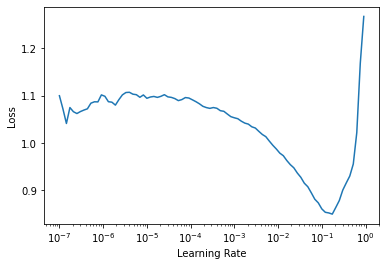

In [ ]:
learner.lr_find()

In [ ]:
learner.fine_tune(5, freeze_epochs=5, base_lr=4e-02)

epoch,train_loss,valid_loss,accuracy_multi,precision_score,recall_score,time
0,0.262430,0.219955,0.901711,0.793210,0.484459,02:07
1,0.236685,0.140950,0.943176,0.912099,0.622682,02:07
2,0.223875,0.231062,0.911898,0.867590,0.534463,02:08
3,0.231313,0.168611,0.937366,0.701154,0.599821,02:07
4,0.219107,0.218979,0.947951,0.739961,0.608193,02:07


/opt/conda/envs/fastai/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


epoch,train_loss,valid_loss,accuracy_multi,precision_score,recall_score,time
0,0.190948,1.034302,0.945484,0.684350,0.635341,02:40
1,0.182674,0.179114,0.946200,0.727299,0.608937,02:40
2,0.148744,0.276217,0.945324,0.748696,0.659856,02:40
3,0.116810,0.084821,0.973498,0.912984,0.870922,02:40
4,0.105020,0.084290,0.970633,0.894279,0.858708,02:40


In [ ]:
learner.save("ResNet18-stage1")

Path('models/ResNet18-stage1.pth')

SuggestedLRs(lr_min=7.585775847473997e-08, lr_steep=9.12010818865383e-07)

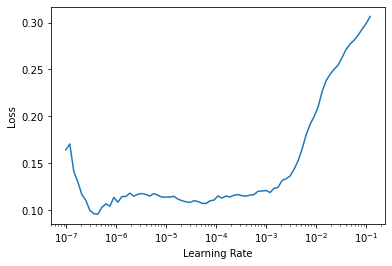

In [ ]:
learner.lr_find()

In [ ]:
learner.fine_tune(3, freeze_epochs=2, base_lr=2e-05)

epoch,train_loss,valid_loss,accuracy_multi,precision_score,recall_score,time
0,0.101866,0.089507,0.972304,0.903250,0.867009,02:08
1,0.100384,0.164022,0.969996,0.870913,0.860113,02:08


epoch,train_loss,valid_loss,accuracy_multi,precision_score,recall_score,time
0,0.103201,0.154043,0.971826,0.893027,0.869984,02:40
1,0.100021,0.200801,0.969837,0.872620,0.862534,02:40
2,0.103101,0.072056,0.973896,0.922391,0.870910,02:40


In [ ]:
model = learner.model[0]
saving_path = Path("models") / "ResNet18-2_class.pt"
torch.save(model.state_dict(), saving_path)

### Old model without fine-tuning

Trying to replicate the result below with more metrics.

In [ ]:
dls = get_classification_dls(bs, with_tfms=False)

In [ ]:
learner = cnn_learner(dls=dls, arch=arch, metrics=metrics, pretrained=True)

In [ ]:
# to train
learner.fit_one_cycle(10, lr_max=slice(1e-02, 1e-03)) # Without aug_transforms

epoch,train_loss,valid_loss,accuracy_multi,time
0,0.713014,0.450069,0.784481,01:59
1,0.346893,0.203011,0.941584,01:59
2,0.148115,0.159998,0.935058,01:59
3,0.110250,0.105488,0.959252,01:59
4,0.095757,0.087816,0.968404,01:59
5,0.079739,0.090750,0.963072,01:59
6,0.065678,0.065018,0.975408,01:59
7,0.050266,0.065378,0.974692,01:59
8,0.043578,0.061543,0.975726,01:59
9,0.042188,0.060365,0.977477,01:59


In [ ]:
learner.fit_one_cycle(10, lr_max=slice(1e-02, 1e-03)) # Without aug_transforms

epoch,train_loss,valid_loss,accuracy_multi,time
0,0.713014,0.450069,0.784481,01:59
1,0.346893,0.203011,0.941584,01:59
2,0.148115,0.159998,0.935058,01:59
3,0.110250,0.105488,0.959252,01:59
4,0.095757,0.087816,0.968404,01:59
5,0.079739,0.090750,0.963072,01:59
6,0.065678,0.065018,0.975408,01:59
7,0.050266,0.065378,0.974692,01:59
8,0.043578,0.061543,0.975726,01:59
9,0.042188,0.060365,0.977477,01:59


In [ ]:
# learner.export(fname="res18_class.pkl") # deleted

With Pytorch API we can save the parameters of the model. This will keep the model "handy" and, if we want to put in production this later, we only need to create an instance and then load the parameters back to it.

In [ ]:
# model = learner.model[0]
# saving_path = Path("models") / "ResNet18_class.pt"
# torch.save(model.state_dict(), saving_path)

In [ ]:
# learner.show_results(nrows=3, ncols=1, figsize=(60,10))

## ResNet34

In [ ]:
arch = partial(resnet34, pretrained=True)

In [ ]:
dls = get_classification_dls(bs)

In [ ]:
x,y = dls.one_batch()
x.shape, y.shape

((64, 3, 256, 1600), (64, 5))

In [ ]:
learner = cnn_learner(dls=dls, arch=arch, metrics=metrics, pretrained=True)

SuggestedLRs(lr_min=0.017378008365631102, lr_steep=0.02754228748381138)

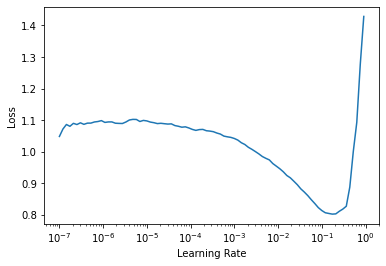

In [ ]:
learner.lr_find()

In [ ]:
learner.fine_tune(3, freeze_epochs=5, base_lr=4e-02)

epoch,train_loss,valid_loss,accuracy_multi,precision_score,recall_score,time
0,0.296307,0.192686,0.926064,0.670884,0.535487,03:15
1,0.223530,0.138570,0.944926,0.888958,0.654579,03:14
2,0.186144,0.128897,0.949702,0.896540,0.704127,03:13
3,0.178454,0.113506,0.956705,0.714842,0.680277,03:15
4,0.173593,0.114278,0.958456,0.864536,0.818646,03:14


/opt/conda/envs/fastai/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


epoch,train_loss,valid_loss,accuracy_multi,precision_score,recall_score,time
0,0.164988,0.189185,0.934978,0.733566,0.579449,04:09
1,0.136072,0.081188,0.967927,0.923696,0.850412,04:08
2,0.099967,0.066188,0.973975,0.916129,0.874275,04:08


In [ ]:
# learner.save("ResNet34-stage1")

Path('models/ResNet34-stage1.pth')

SuggestedLRs(lr_min=8.31763736641733e-07, lr_steep=2.75422871709452e-06)

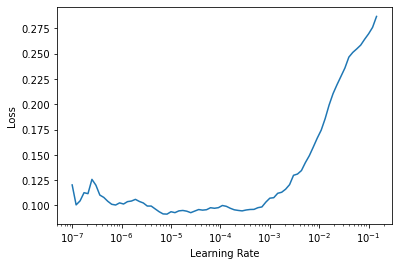

In [ ]:
learner.lr_find()

In [ ]:
learner.fine_tune(2, base_lr=1e-05)

epoch,train_loss,valid_loss,accuracy_multi,precision_score,recall_score,time
0,0.093264,0.068900,0.974134,0.919756,0.879792,03:14


epoch,train_loss,valid_loss,accuracy_multi,precision_score,recall_score,time
0,0.094757,0.067091,0.974532,0.919687,0.882430,04:09
1,0.097796,0.066890,0.974851,0.918190,0.886756,04:08


In [ ]:
model = learner.model[0]
saving_path = Path("models") / "ResNet34_class.pt"
torch.save(model.state_dict(), saving_path)

## ResNet50

In [ ]:
dls = get_classification_dls(bs//2)

In [ ]:
x,y = dls.one_batch()
x.shape, y.shape

((32, 3, 256, 1600), (32, 5))

In [ ]:
arch = partial(resnet50, pretrained=True)

In [ ]:
learner = cnn_learner(dls=dls, arch=arch, metrics=metrics, pretrained=True)

SuggestedLRs(lr_min=0.014454397559165954, lr_steep=1.3182567499825382e-06)

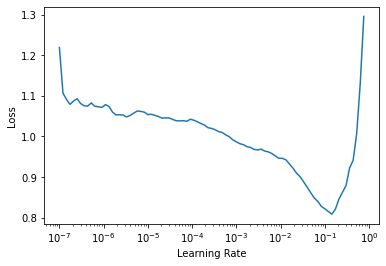

In [ ]:
learner.lr_find()

In [ ]:
learner.fine_tune(3, freeze_epochs=5, base_lr=3e-2)

epoch,train_loss,valid_loss,accuracy_multi,precision_score,recall_score,time
0,0.248172,0.168877,0.936490,0.711180,0.544261,07:18
1,0.209768,0.127209,0.948190,0.935723,0.604909,07:18
2,0.190299,0.154087,0.938798,0.888714,0.630990,07:18
3,0.179573,0.180462,0.932989,0.882808,0.628516,07:18
4,0.190584,0.106148,0.959093,0.939538,0.679204,07:18


/opt/conda/envs/fastai/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


epoch,train_loss,valid_loss,accuracy_multi,precision_score,recall_score,time
0,0.198997,0.118798,0.955352,0.861289,0.845442,09:33
1,0.149691,0.093528,0.966176,0.928932,0.814771,09:33
2,0.115153,0.070484,0.971906,0.935100,0.861000,09:33


In [ ]:
learner.save("Resnet50-stage1")

Path('models/Resnet50-stage1.pth')

SuggestedLRs(lr_min=9.12010818865383e-08, lr_steep=6.309573450380412e-07)

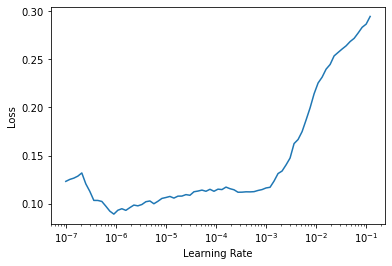

In [ ]:
learner.lr_find()

In [ ]:
learner.fine_tune(3, freeze_epochs=1, base_lr=3e-5)

epoch,train_loss,valid_loss,accuracy_multi,precision_score,recall_score,time
0,0.105032,0.073506,0.970553,0.930518,0.858084,07:21


epoch,train_loss,valid_loss,accuracy_multi,precision_score,recall_score,time
0,0.105284,0.068816,0.972543,0.935281,0.868948,09:33
1,0.102424,0.070865,0.972145,0.934479,0.861260,09:33
2,0.100892,0.073683,0.970314,0.941188,0.848564,09:33


In [ ]:
model = learner.model[0]
saving_path = Path("models") / "ResNet50_class.pt"
torch.save(model.state_dict(), saving_path)

# Export

In [ ]:
#!python notebook2script.py 03c_classifier_model.ipynb

Converted 03c_classifier_model.ipynb to exp/nb_03c.py
